# True Solution and Quick Verification

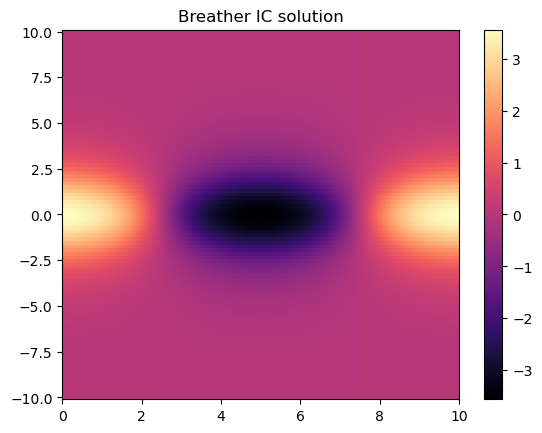

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import pickle
import os

from constrained_nn_eq_discovery import numerics
from constrained_nn_eq_discovery import utils
from constrained_nn_eq_discovery import dhpm
from constrained_nn_eq_discovery import con_opt
from constrained_nn_eq_discovery import training

import importlib
importlib.reload(utils)
importlib.reload(training)

# set cmap for this notebook
plt.rcParams['image.cmap'] = 'magma'

ic = 'breather'
# ic = 'custom'

n_x = 100
n_t = 2000
x = torch.linspace(-10, 10, n_x)
t = torch.linspace(0, 10, n_t)
X, T = torch.meshgrid(x, t, indexing='ij')
plt.figure()
if ic == 'breather':
    U_true = utils.breather(X, T)
    ic_fn = utils.breather_ic
    uv0 = ic_fn(x)
    plt.title("Breather IC solution")
elif ic == 'custom':
    # show ic
    ic_fn = utils.custom_ic
    uv0 = utils.custom_ic(x)
    # solve with FD to get data
    U_true = numerics.solve_pde_2nd_in_time(uv0, x, t, utils.sine_gordon).T
    plt.title("Custom IC solution")
plt.pcolor(T, X, U_true)
cbar = plt.colorbar(plt.pcolor(T, X, U_true))

# Begin Actual Study

Data shape: torch.Size([20, 25])
Device: cuda
l2 nn: 0.99731, l2 pde: 4.60136


Text(0.5, 1.0, 'Before training')

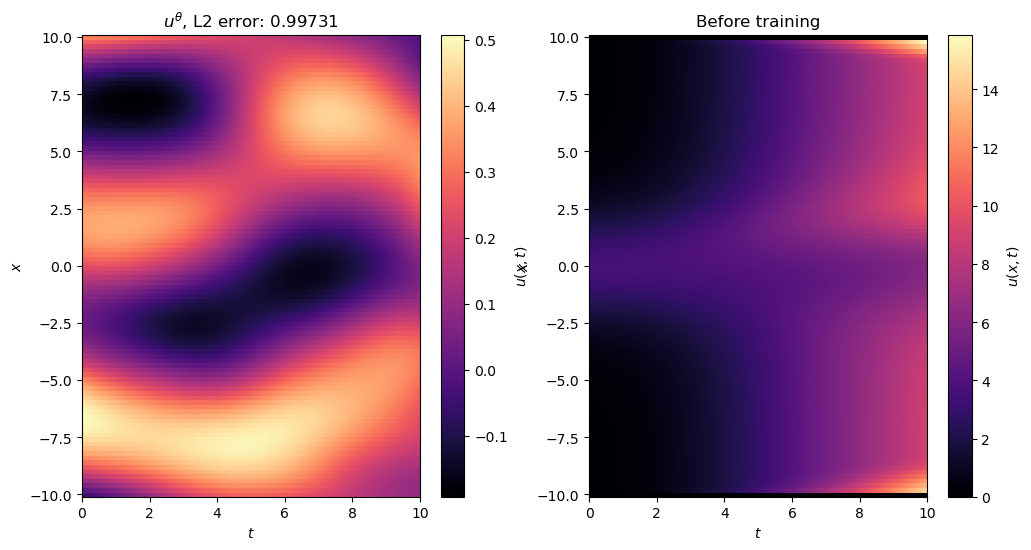

In [25]:
class debugN(nn.Module):
    def __init__(self, p1=-1.0, p2=1.0):
        super().__init__()
        self.p1 = nn.Parameter(torch.tensor(p1))
        self.p2 = nn.Parameter(torch.tensor(p2))

    def forward(self, big_u):
        u = big_u[:, 0:1]
        uxx = big_u[:, 2:3]
        return self.p1 * torch.sin(u) + self.p2 * uxx


torch.manual_seed(0)
noise_level = 0.0
ss_x = 5
ss_t = 80
identifier_str = f'ssx{ss_x}_sst{ss_t}_nl{noise_level}_nx{n_x}_nt{n_t}_{ic}'
U_data, X_data, T_data = utils.get_data(U_true, X, T, noise_level, ss_x, ss_t)
utils.save_data(U_data, X_data, T_data, '../data/'+identifier_str)
save_folder = f'../models/' + identifier_str
print(f'Data shape: {U_data.shape}')
os.makedirs(save_folder, exist_ok=True)

u_layers = [2, 32, 32, 1]
N_layers = [3, 16, 16, 1]
act = 'sin'
u_dnn = dhpm.DNN(u_layers, act)
N_dnn = dhpm.DNN(N_layers, 'sin')
# N_dnn = debugN(0.0, 0.0)
model = dhpm.EqDiscoveryModel(u_dnn, N_dnn)

def get_pde_error(N):
    with torch.no_grad():
        U_pde = numerics.solve_pde_2nd_in_time(uv0, x, t, N).T
    l2_error_pde = utils.l2_error(U_true, U_pde)
    return l2_error_pde, U_pde

def plot_model():
    with torch.no_grad():
        U_nn = model.u_on_meshgrid(T, X)
    l2_error = utils.l2_error(U_true, U_nn)
    l2_error_pde, U_pde = get_pde_error(model.N_dnn)
    print(f'l2 nn: {l2_error:.5f}, l2 pde: {l2_error_pde:.5f}')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].pcolor(T, X, U_nn)
    cbar = plt.colorbar(ax[0].pcolor(T, X, U_nn))
    cbar.set_label("$u(x,t)$")
    ax[1].pcolor(T, X, U_pde)
    cbar = plt.colorbar(ax[1].pcolor(T, X, U_pde))
    cbar.set_label("$u(x,t)$")
    ax[0].set_title(rf"$u^\theta$, L2 error: {l2_error:.5f}")
    ax[1].set_title(rf"$N^\phi$ PDE solution, L2 error: {l2_error_pde:.5f}")
    # x and y labels, colobar label
    for a in ax:
        a.set_xlabel("$t$")
        a.set_ylabel("$x$")
    return fig, ax

# convert from 2D to 1D (b, 1), and (b, 2) for xt
u_train = U_data.reshape(-1, 1)
xt_train = torch.cat([X_data.reshape(-1, 1), T_data.reshape(-1, 1)], dim=1)
xt_f = torch.cat([X_data.reshape(-1, 1), T_data.reshape(-1, 1)], dim=1).requires_grad_(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f'Device: {device}')

plot_model()
plt.title('Before training')

In [26]:
# lr = 1e-3
# epochs = 5000
# # lam = 0
# lam = 1e0

# base_fname = f'{save_folder}/dhpm_lr{lr}_e{epochs}_lam{lam}.pkl'
# if os.path.exists(base_fname):
#     print(f'Loading model from {base_fname}')
#     with open(base_fname, 'rb') as f:
#         model = pickle.load(f)
# else:
#     print(f'Did not load model')
#     training_config = {
#             'epochs': epochs,
#             'learning_rate': lr,
#             'lam': lam,
#             # 'optimizer_type': 'LBFGS',
#             'optimizer_type': 'Adam',
#             'params': ['u', 'N'],
#             # 'params': ['u', 'N', 'lams'],
#         }
#     model.to(device)
#     xt_train = xt_train.to(device)
#     u_train = u_train.to(device)
#     xt_f = xt_f.to(device)

#     if 'lams' in training_config['params']:
#         tracker, lams = training.train_dhpm(model, xt_train, u_train, xt_f, training_config)
#     else:
#         tracker = training.train_dhpm(model, xt_train, u_train, xt_f, training_config)
#     tracker.plot_training_history()

#     # back to cpu
#     model = model.cpu()
#     xt_train = xt_train.cpu()
#     u_train = u_train.cpu()
#     xt_f = xt_f.cpu()

#     # save model
#     with open(base_fname, 'wb') as f:
#         pickle.dump(model, f)

# plot_model()
# plt.suptitle(f'Initial DHPM Training')

Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i0_eps100.0_of10.pkl
l2 nn: 0.01881, l2 pde: 1.61991
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i1_eps10.0_of10.pkl
l2 nn: 0.01527, l2 pde: 0.63989
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i2_eps1.0_of10.pkl
l2 nn: 0.01541, l2 pde: 0.65664
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i3_eps0.1_of10.pkl
l2 nn: 0.01004, l2 pde: 0.13848
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i4_eps0.01_of10.pkl
l2 nn: 0.01114, l2 pde: 0.12095
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i5_eps0.001_of10.pkl
l2 nn: 0.01413, l2 pde: 0.10879
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i6_eps0.0001_of10.pkl
l2 nn: 0.01603, l2 pde: 0.09354
Loading model from ../models/ssx5_sst80_nl0.0_nx100_nt2000_breather/dhpm_eps_i7_eps1e-05_of10.p

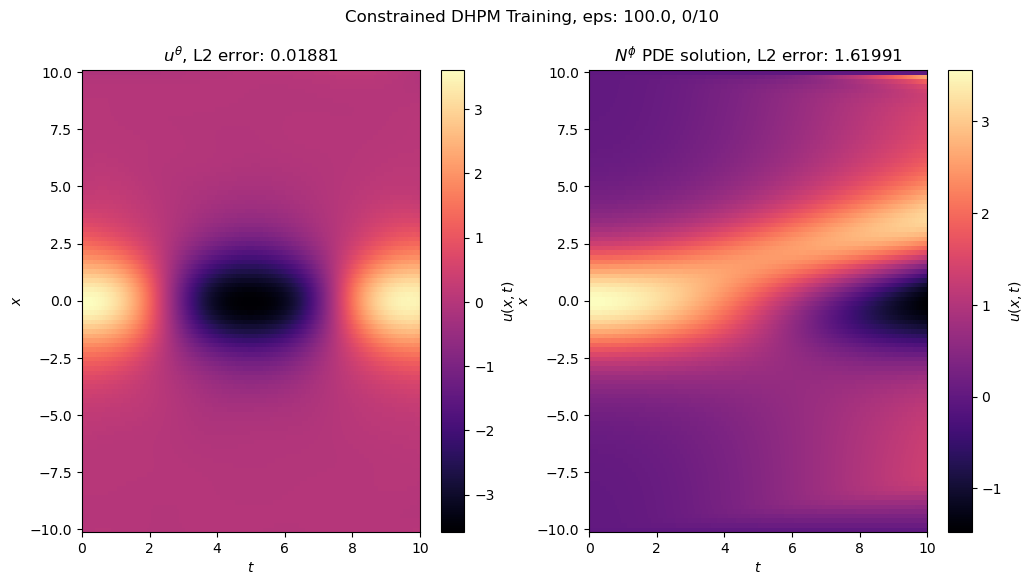

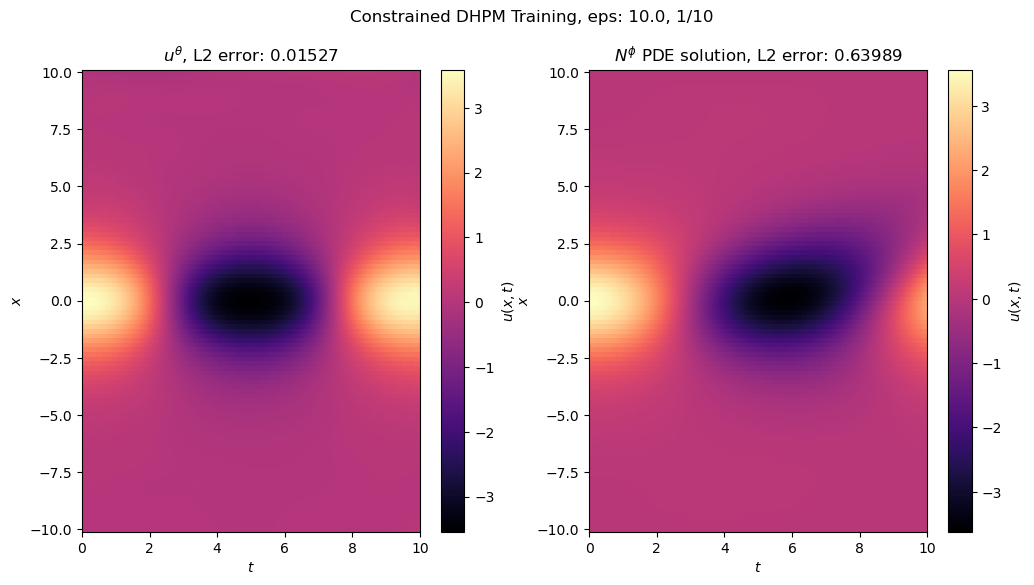

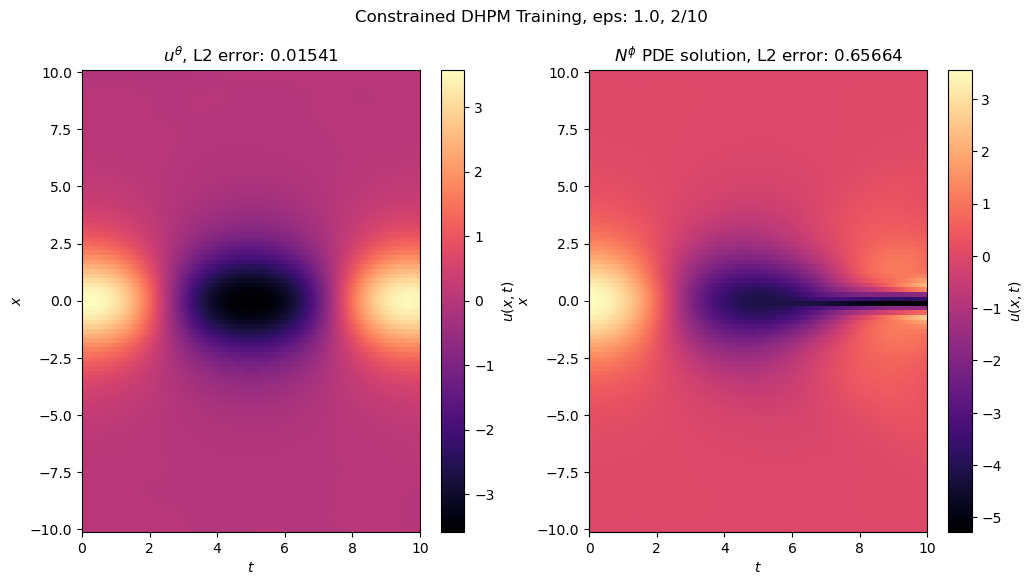

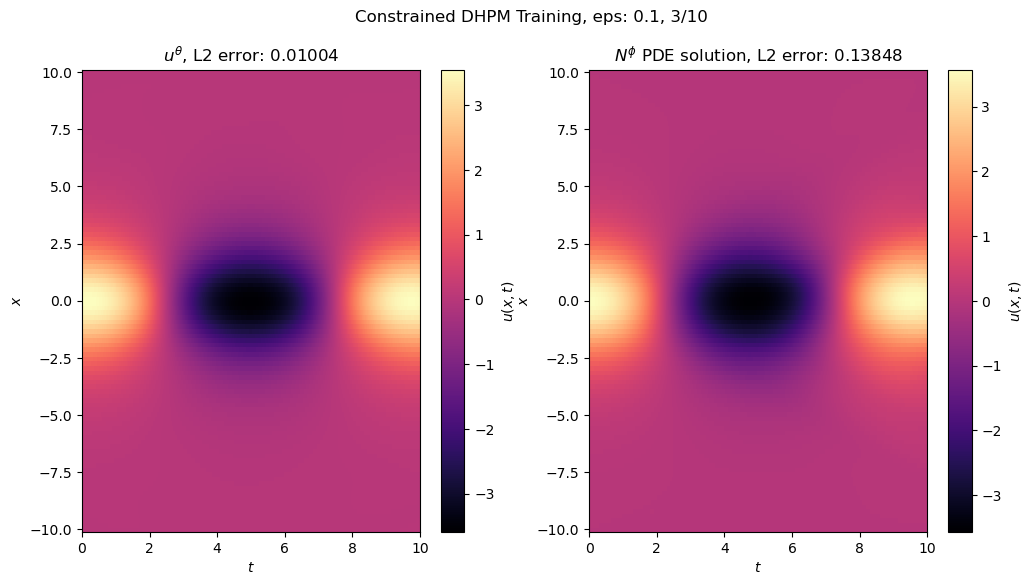

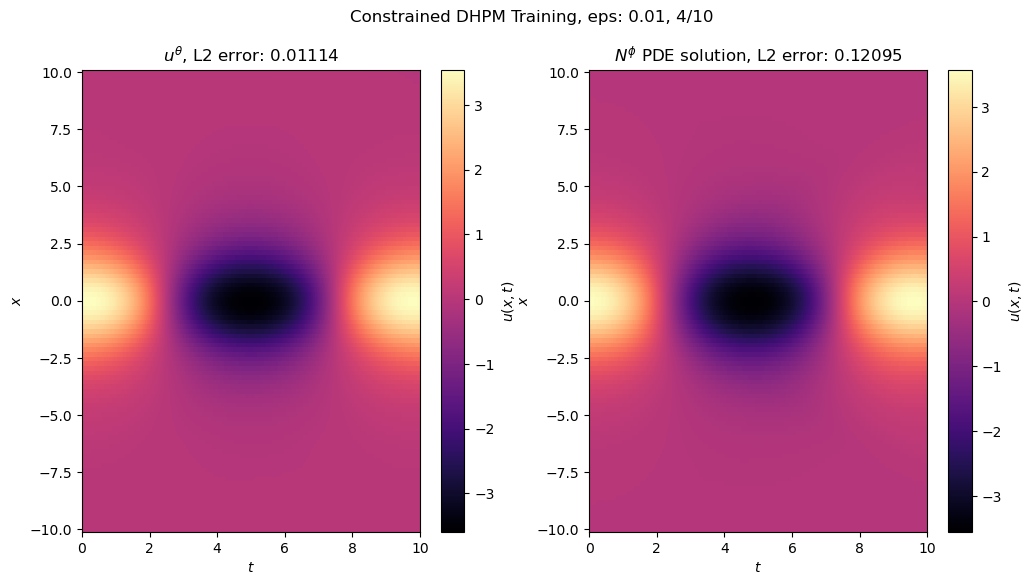

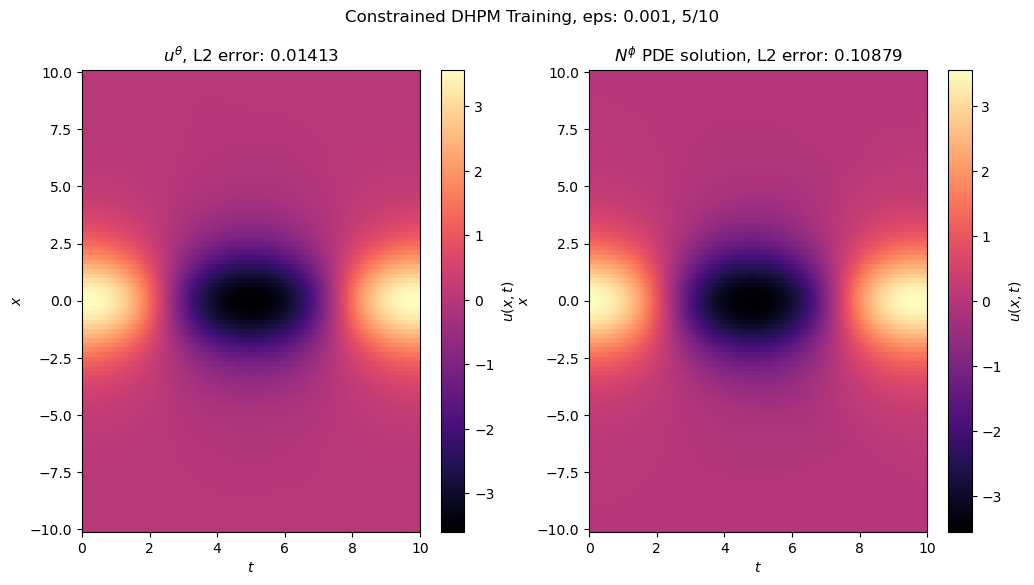

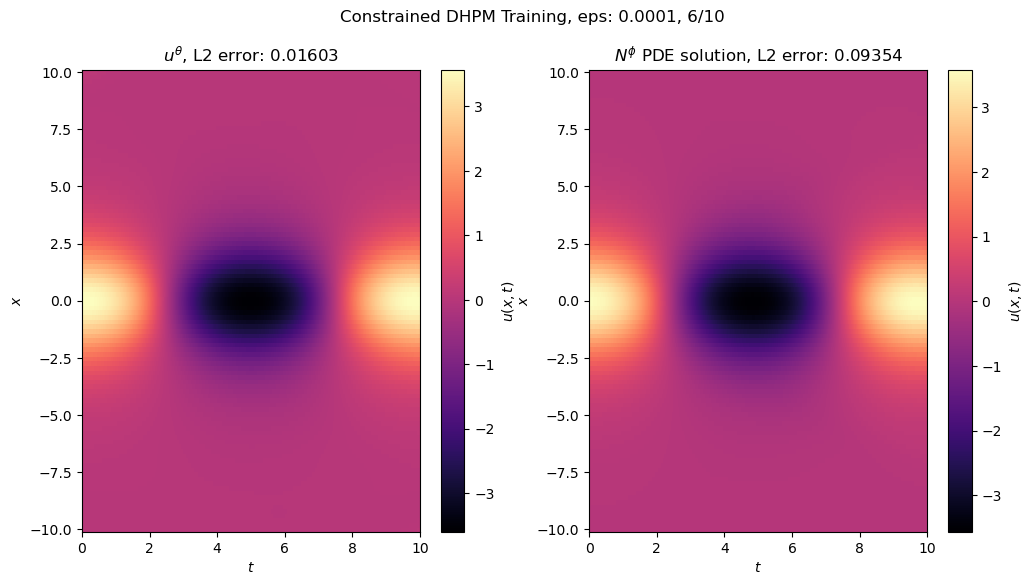

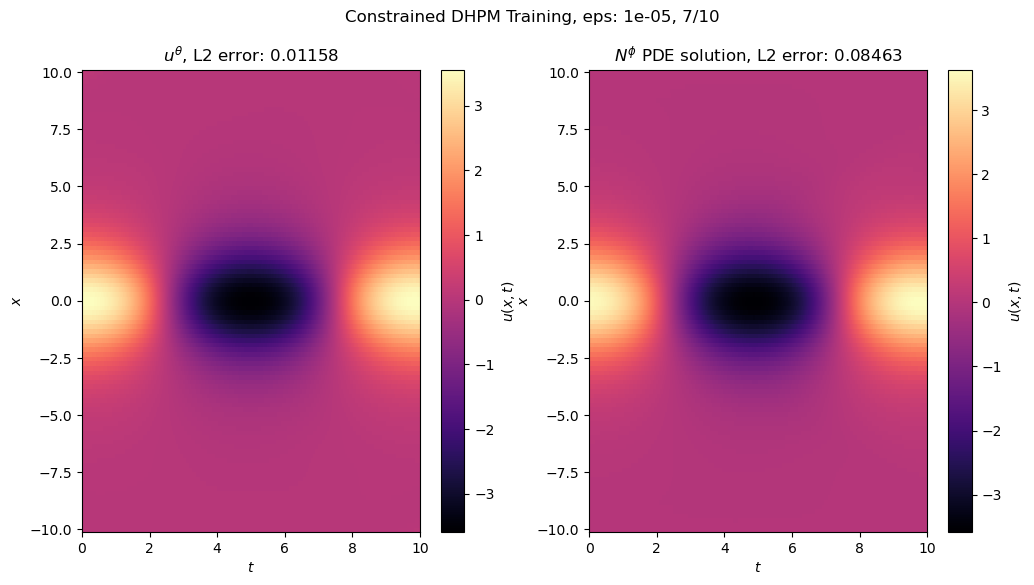

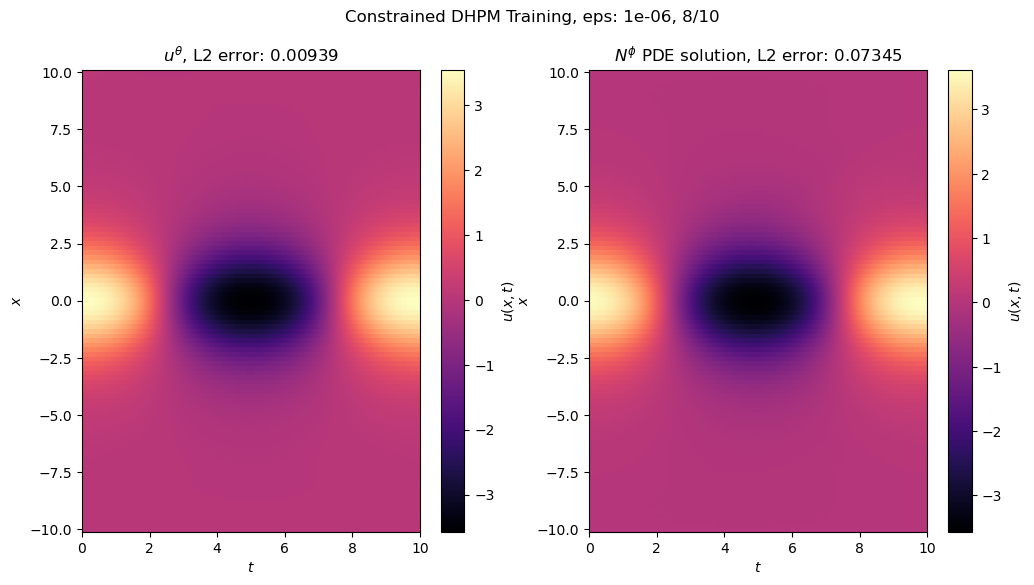

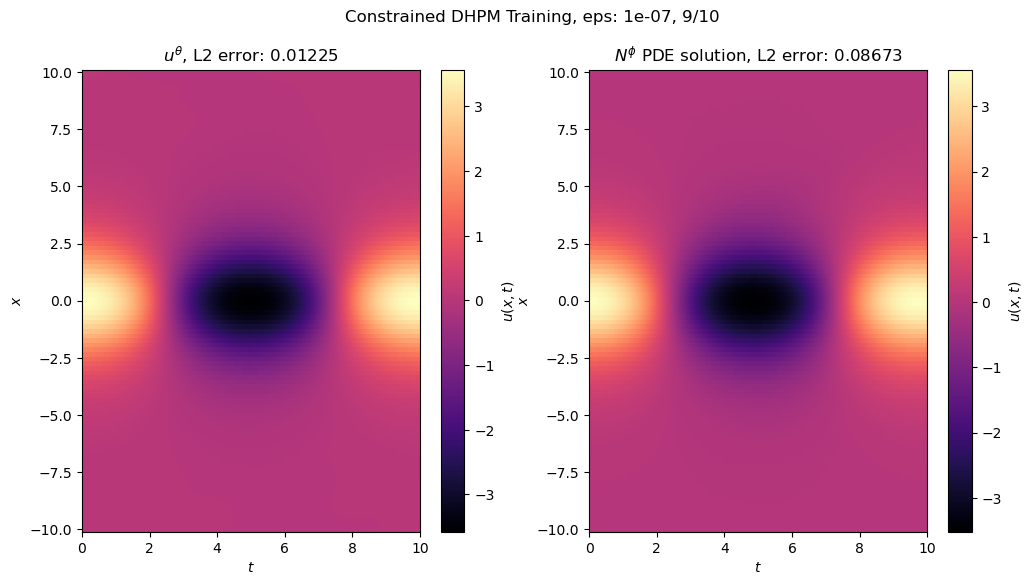

In [27]:
epses = [1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
# epses = [1e-2]
for eps_index, eps in enumerate(epses):
    eps_fname = f'{save_folder}/dhpm_eps_i{eps_index}_eps{eps}_of{len(epses)}.pkl'
    if os.path.exists(eps_fname):
        print(f'Loading model from {eps_fname}')
        with open(eps_fname, 'rb') as f:
            model = pickle.load(f)
    else:
        training_config = {
                'epochs': 1000,
                'eps': eps,
                'verbosity': 1
            }
        tracker, res = training.train_dhpm_constrained(model, xt_train, u_train, xt_f, training_config)
        with open(eps_fname, 'wb') as f:
            pickle.dump(model, f)
    plot_model()
    plt.suptitle(f'Constrained DHPM Training, eps: {eps}, {eps_index+1}/{len(epses)}')

In [28]:
# Get the WSINDy model
import matlab_sindy_results
# reload
importlib.reload(matlab_sindy_results)
# N_sindy = matlab_sindy_results.get_wsindy_model(identifier_str, m=3)
N_sindy = matlab_sindy_results.get_wsindy_model('ssx5_sst80_nl0.0_nx100_nt2000_breather', m=4)
# N_sindy = matlab_sindy_results.get_wsindy_model('ssx1_sst1_nl0.0_nx100_nt2000_breather')

l2_error_sindy, U_pde_sindy = get_pde_error(N_sindy)
print(f'WSINDy error: {l2_error_sindy:.5f}')
plt.figure()
plt.pcolor(T, X, U_pde_sindy)

ModuleNotFoundError: No module named 'matlab_sindy_results'